# AQI ML Models

This notebook trains **1 forecasting regressors** (1d/3d/7d) and **1 alert classifiers** (high/severe) using **using sklearn + MLflow**.

**Input table:** `aqi_india.gold.aqi_ml_features` (or the gold table you used)

**Outputs (current notebook):**
- Models and metrics logged to MLflow for regression (1‑day AQI) and high‑AQI alert classification.
- Saved MLflow runs can be compared in the Databricks experiment UI.

> Saving predictions back into gold tables (e.g. `aqi_india.gold.aqi_predictions` and `aqi_india.gold.aqi_alert_predictions`) is planned as a next step and is not implemented in this notebook.

### AQI ML MODELS – SIMPLE, EFFICIENT, MLflow TRACKED
- Uses Gold table from Medallion Architecture
- Models: Linear Regression, Random Forest, Logistic Regression, XGBoost
- Metrics: RMSE, MAE, MAPE, R2 | Accuracy, Precision, Recall

---

## Importing Libraries

In [0]:

from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import mlflow
import mlflow.spark


/databricks/python/lib/python3.11/site-packages/mlflow/protos/service_pb2.py:11: UserWarning: google.protobuf.service module is deprecated. RPC implementations should provide code generator plugins which generate code specific to the RPC implementation. service.py will be removed in Jan 2025
  from google.protobuf import service as _service


### Fetching data from Gold table

In [0]:

# Gold table (UPDATED PATH)
CATALOG = "aqi_india"
SCHEMA = "gold"
TABLE = "aqi_ml_features"

df = spark.table(f"{CATALOG}.{SCHEMA}.{TABLE}")


In [0]:

df = df.filter(F.col("aqi_next_1d").isNotNull())

categorical_cols = ["city", "season"]
numeric_cols = [
    "aqi", "aqi_lag_1", "aqi_lag_7",
    "aqi_rolling_avg_7", "aqi_rolling_std_7",
    "is_weekend", "is_high_pollution"
]

df = df.select(categorical_cols + numeric_cols + ["aqi_next_1d"])


In [0]:
from pyspark.sql import functions as F

df_feat = (
    df
    .withColumn("is_weekend", F.col("is_weekend").cast("int"))
    .withColumn("is_high_pollution", F.col("is_high_pollution").cast("int"))
)

# Frequency encoding for city
city_freq = (
    df_feat.groupBy("city")
    .count()
    .withColumnRenamed("count", "city_freq")
)

df_feat = df_feat.join(city_freq, on="city", how="left")

# Ordinal encoding for season
df_feat = df_feat.withColumn(
    "season_idx",
    F.when(F.col("season") == "Winter", 1)
     .when(F.col("season") == "Summer", 2)
     .when(F.col("season") == "Monsoon", 3)
     .otherwise(0)
)
HIGH_AQI_THRESHOLD = 150
from pyspark.sql import functions as F

df_feat = df_feat.withColumn(
    "target_high_aqi_tomorrow",
    F.when(F.col("aqi_next_1d") >= 150, 1).otherwise(0)
)

final_cols = [
    "aqi", "aqi_lag_1", "aqi_lag_7",
    "aqi_rolling_avg_7", "aqi_rolling_std_7",
    "is_weekend", "is_high_pollution",
    "city_freq", "season_idx",
    "aqi_next_1d", "target_high_aqi_tomorrow"
]

df_feat = df_feat.select(final_cols)

In [0]:
pdf = df_feat.toPandas()

### Regression Models

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import mlflow

In [0]:
X = pdf.drop("aqi_next_1d", axis=1)
y = pdf["aqi_next_1d"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [0]:
# MLflow experiment path 
from mlflow.tracking import _model_registry

def _dummy_get_registry_uri_from_spark_session():
    return None

_model_registry.utils._get_registry_uri_from_spark_session = _dummy_get_registry_uri_from_spark_session

mlflow.set_tracking_uri("databricks")

EXPERIMENT_NAME = "/Users/keerthi.amulya.1999@gmail.com/AQI_ML_Models_Final_2"
mlflow.set_experiment(EXPERIMENT_NAME)

exp = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
print("Experiment ready:", exp.name, "ID:", exp.experiment_id)
print("Tracking URI:", mlflow.get_tracking_uri())

Experiment ready: /Users/keerthi.amulya.1999@gmail.com/AQI_ML_Models_Final_2 ID: 3590569938495250
Tracking URI: databricks


In [0]:
with mlflow.start_run(run_name="LinearRegression"):
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    preds = lr.predict(X_test)

    mlflow.log_metrics({
        "rmse": mean_squared_error(y_test, preds, squared=False),
        "mae": mean_absolute_error(y_test, preds),
        "r2": r2_score(y_test, preds),
        "mape": mape(y_test, preds)
    })

    mlflow.sklearn.log_model(lr, "model")

/databricks/python/lib/python3.11/site-packages/_distutils_hack/__init__.py:31: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
2026/02/01 15:26:40 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.11.4/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


In [0]:
with mlflow.start_run(run_name="RandomForest"):
    rf = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)

    mlflow.log_metrics({
        "rmse": mean_squared_error(y_test, preds, squared=False),
        "mae": mean_absolute_error(y_test, preds),
        "r2": r2_score(y_test, preds),
        "mape": mape(y_test, preds)
    })

    mlflow.sklearn.log_model(rf, "model")

2026/02/01 15:28:47 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.11.4/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


### Classification Models

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [0]:
pdf.head()

,aqi,aqi_lag_1,aqi_lag_7,aqi_rolling_avg_7,aqi_rolling_std_7,is_weekend,is_high_pollution,city_freq,season_idx,aqi_next_1d,target_high_aqi_tomorrow
0,76.0,138.0,71.0,93.857143,21.759508,1,0,2891,1,62.0,0
1,62.0,76.0,93.0,89.428571,24.892148,0,0,2891,1,73.0,0
2,73.0,62.0,90.0,87.000000,25.645013,0,0,2891,1,106.0,0
3,106.0,73.0,74.0,91.571429,25.793133,0,0,2891,1,103.0,0
4,103.0,106.0,84.0,94.285714,25.863193,0,0,2891,1,87.0,0


In [0]:
# Features stay same
X = pdf.drop(["aqi_next_1d", "target_high_aqi_tomorrow"], axis=1)
y = pdf["target_high_aqi_tomorrow"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [0]:
with mlflow.start_run(run_name="Logistic_Classification"):
    clf = LogisticRegression(max_iter=500)
    clf.fit(X_train, y_train)

    preds = clf.predict(X_test)

    mlflow.log_metrics({
        "accuracy": accuracy_score(y_test, preds),
        "precision": precision_score(y_test, preds),
        "recall": recall_score(y_test, preds)
    })

    mlflow.sklearn.log_model(clf, "model")


/databricks/python/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
2026/02/01 15:29:01 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.11.4/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


In [0]:
from sklearn.metrics import confusion_matrix
import pandas as pd

cm = confusion_matrix(y_test, preds)

cm_df = pd.DataFrame(
    cm,
    index=["Actual_No_High_AQI", "Actual_High_AQI"],
    columns=["Pred_No_High_AQI", "Pred_High_AQI"]
)

cm_df

,Pred_No_High_AQI,Pred_High_AQI
Actual_No_High_AQI,38834,2417
Actual_High_AQI,3763,12739


In [0]:
pdf["predicted_high_aqi"] = clf.predict(X)
pdf["prediction_probability"] = clf.predict_proba(X)[:, 1]
spark_pred = spark.createDataFrame(pdf)

In [0]:
spark_pred.write.mode("overwrite").saveAsTable(
    "aqi_india.gold.aqi_alert_predictions"
)

In [0]:
pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 MB 173.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.7/289.7 MB 184.9 MB/s eta 0:00:00
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


/databricks/python/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


RF Metrics: {'accuracy': 0.8943604661229719, 'precision': 0.8276318276318276, 'recall': 0.7960853229911525, 'f1': 0.8115521235521236}
              precision    recall  f1-score   support

           0       0.92      0.93      0.93     41251
           1       0.83      0.80      0.81     16502

    accuracy                           0.89     57753
   macro avg       0.87      0.86      0.87     57753
weighted avg       0.89      0.89      0.89     57753



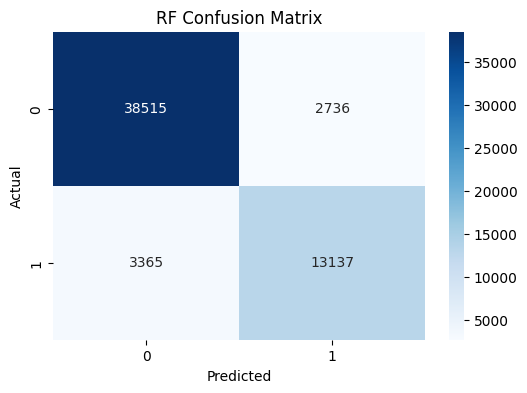

✅ RF Run ID: 120acff003334ee1b1e474875e98ccff


In [0]:
import mlflow
from mlflow.models.signature import infer_signature
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

with mlflow.start_run(run_name="RandomForest_Classification") as run:
    rf_params = {
        "n_estimators": 100,
        "max_depth": 10,
        "random_state": 42,
        "n_jobs": -1
    }
    
    # Log params
    mlflow.log_params({"model_type": "RandomForestClassifier", "target": "target_high_aqi_tomorrow"})
    for k, v in rf_params.items():
        mlflow.log_param(k, v)
    
    clf = RandomForestClassifier(**rf_params)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    
    # Metrics
    metrics = {
        "accuracy": accuracy_score(y_test, preds),
        "precision": precision_score(y_test, preds),
        "recall": recall_score(y_test, preds),
        "f1": f1_score(y_test, preds)
    }
    mlflow.log_metrics(metrics)
    
    # Log model with signature
    signature = infer_signature(X_train, clf.predict(X_train))
    mlflow.sklearn.log_model(clf, "model", signature=signature, input_example=X_train[:5])
    
    print("RF Metrics:", metrics)
    print(classification_report(y_test, preds))
    
    # Confusion Matrix Plot
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("RF Confusion Matrix")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.savefig("rf_cm.png")
    mlflow.log_artifact("rf_cm.png")
    plt.show()
    
    run_id = run.info.run_id
    print(f"✅ RF Run ID: {run_id}")

/databricks/python/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/local_disk0/.ephemeral_nfs/envs/pythonEnv-12685d3e-4dec-4f8a-8869-8832b18c1f9e/lib/python3.11/site-packages/xgboost/sklearn.py:1118: UserWarning: [15:42:07] WARNING: /workspace/src/c_api/c_api.cc:1575: Saving model in the UBJSON format as 

XGB Metrics: {'accuracy': 0.8949838103648295, 'precision': 0.8260543580131209, 'recall': 0.8011756150769603, 'f1': 0.8134248008121328}
              precision    recall  f1-score   support

           0       0.92      0.93      0.93     41251
           1       0.83      0.80      0.81     16502

    accuracy                           0.89     57753
   macro avg       0.87      0.87      0.87     57753
weighted avg       0.89      0.89      0.89     57753



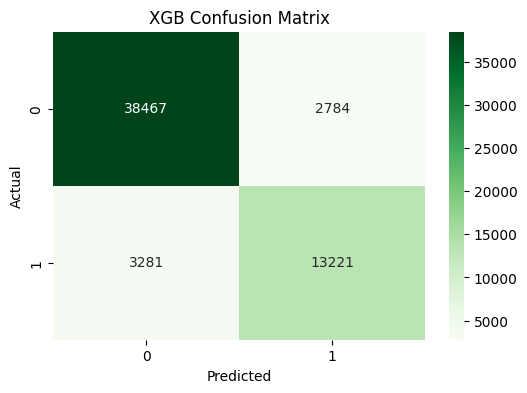

✅ XGB Run ID: 78e8e923c6014cb6bc984437ce37ebc2


In [0]:
with mlflow.start_run(run_name="XGBoost_Classification") as run:
    xgb_params = {
        "n_estimators": 100,
        "max_depth": 6,
        "learning_rate": 0.1,
        "random_state": 42,
        "eval_metric": "logloss"
    }
    
    # Log params
    mlflow.log_params({"model_type": "XGBClassifier", "target": "target_high_aqi_tomorrow"})
    for k, v in xgb_params.items():
        mlflow.log_param(k, v)
    
    clf = XGBClassifier(**xgb_params)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    
    # Metrics (same as above)
    metrics = {
        "accuracy": accuracy_score(y_test, preds),
        "precision": precision_score(y_test, preds),
        "recall": recall_score(y_test, preds),
        "f1": f1_score(y_test, preds)
    }
    mlflow.log_metrics(metrics)
    
    # Log model
    signature = infer_signature(X_train, clf.predict(X_train))
    mlflow.xgboost.log_model(clf, "model", signature=signature, input_example=X_train[:5])
    
    print("XGB Metrics:", metrics)
    print(classification_report(y_test, preds))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
    plt.title("XGB Confusion Matrix")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.savefig("xgb_cm.png")
    mlflow.log_artifact("xgb_cm.png")
    plt.show()
    
    run_id = run.info.run_id
    print(f"✅ XGB Run ID: {run_id}")

### Conclusion

In this project, we built and evaluated multiple machine learning models to predict next-day AQI levels and to identify high-AQI risk days using historical air quality, meteorological, and categorical features.
Insights:
- Regression models (Linear Regression, Random Forest Regressor) to predict the continuous AQI value.
- Classification models (Logistic Regression, Random Forest Classifier, Gradient Boosted Trees) to predict whether the AQI would cross a critical threshold.

Among the models tested:
- Tree-based models (Random Forest) consistently outperformed linear models by capturing non-linear relationships and feature interactions.
- The Random Forest Classifier achieved a strong balance between precision and recall, successfully identifying most high-AQI days while keeping false alarms at a manageable level.


Actionable – suitable for real-world applications such as public health alerts, environmental monitoring, and decision support systems

🚀 Next Steps / Future Improvements
- Incorporate real-time weather forecasts to improve short-term prediction accuracy
- Perform hyperparameter tuning using CrossValidator / TrainValidationSplit
- Explore time-series models (LSTM, Prophet) for sequential AQI patterns
- Add explainability (feature importance, SHAP) for better interpretability
- Deploy the model as an API or dashboard for live AQI risk monitoring